In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


weather = pd.read_csv('df_nivel_rios.csv', index_col='Data')
weather.index = pd.to_datetime(weather.index)
weather = weather.iloc[:, 1:]
weather['target'] = weather.shift(-1)['Nível Guaíba (cm)']
weather = weather.ffill()

In [2]:
weather.apply(pd.isnull).sum()/weather.shape[0]

Nível Caí (cm)            0.0
Nível Jacuí (cm)          0.0
Nível Sinos (cm)          0.0
Nível Gravataí (cm)       0.0
Nível Guaíba (cm)         0.0
HORÁRIO (mm)              0.0
HORARIA (°C)              0.0
UMIDADE RELATIVA DO AR    0.0
VENTO                     0.0
target                    0.0
dtype: float64

In [3]:
weather.dtypes

Nível Caí (cm)            float64
Nível Jacuí (cm)          float64
Nível Sinos (cm)          float64
Nível Gravataí (cm)       float64
Nível Guaíba (cm)         float64
HORÁRIO (mm)              float64
HORARIA (°C)              float64
UMIDADE RELATIVA DO AR    float64
VENTO                     float64
target                    float64
dtype: object

In [4]:
weather.corr()

,Nível Caí (cm),Nível Jacuí (cm),Nível Sinos (cm),Nível Gravataí (cm),Nível Guaíba (cm),HORÁRIO (mm),HORARIA (°C),UMIDADE RELATIVA DO AR,VENTO,target
Nível Caí (cm),1.000000,0.567816,0.703446,0.595508,0.628322,-0.147673,0.020087,-0.048572,-0.010353,0.630083
Nível Jacuí (cm),0.567816,1.000000,0.531729,0.520676,0.754476,-0.052827,-0.000179,-0.052907,-0.012295,0.754049
Nível Sinos (cm),0.703446,0.531729,1.000000,0.771541,0.729262,-0.074102,0.001966,-0.066935,-0.002932,0.729259
Nível Gravataí (cm),0.595508,0.520676,0.771541,1.000000,0.779617,-0.073494,-0.007701,-0.072794,0.000210,0.779513
Nível Guaíba (cm),0.628322,0.754476,0.729262,0.779617,1.000000,-0.086490,0.002264,-0.089515,-0.018883,0.998369
HORÁRIO (mm),-0.147673,-0.052827,-0.074102,-0.073494,-0.086490,1.000000,-0.341344,-0.013782,0.059792,-0.089491
HORARIA (°C),0.020087,-0.000179,0.001966,-0.007701,0.002264,-0.341344,1.000000,0.073397,-0.008944,0.003943
UMIDADE RELATIVA DO AR,-0.048572,-0.052907,-0.066935,-0.072794,-0.089515,-0.013782,0.073397,1.000000,0.328740,-0.091195
VENTO,-0.010353,-0.012295,-0.002932,0.000210,-0.018883,0.059792,-0.008944,0.328740,1.000000,-0.021510
target,0.630083,0.754049,0.729259,0.779513,0.998369,-0.089491,0.003943,-0.091195,-0.021510,1.000000


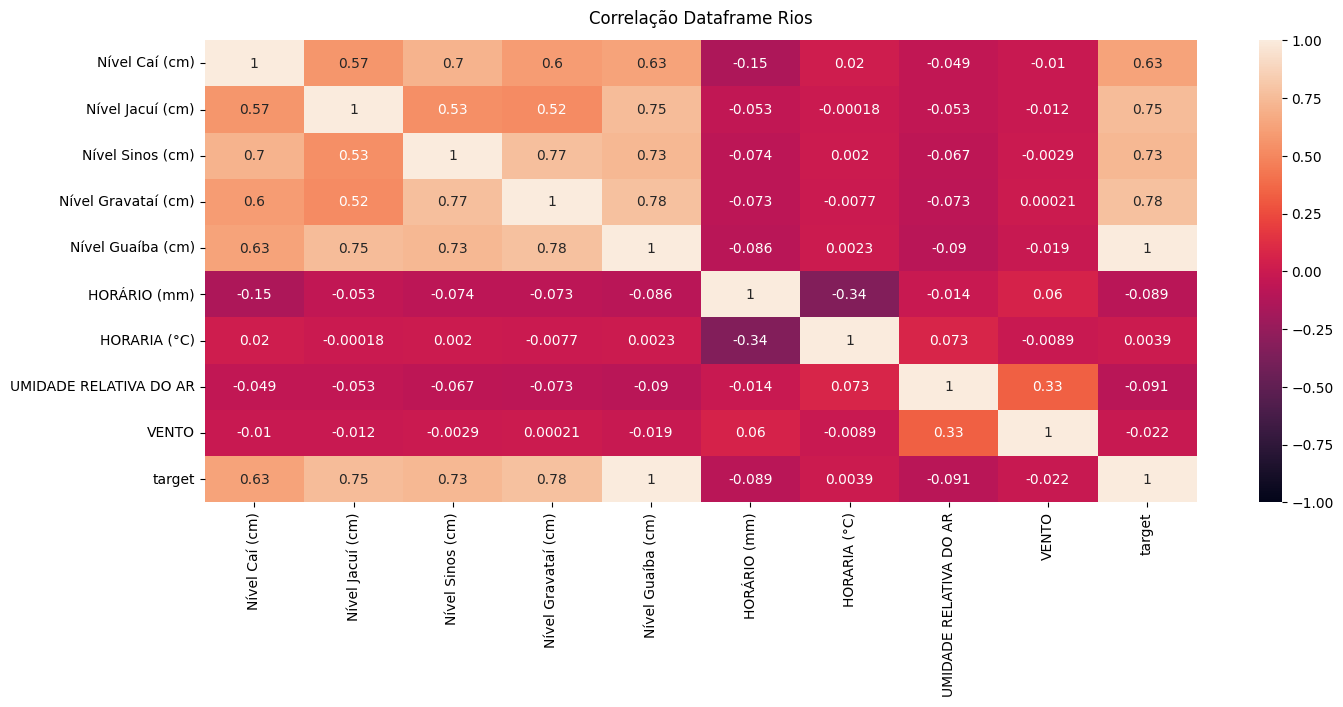

In [5]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(weather.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlação Dataframe Rios', fontdict={'fontsize':12}, pad=12);

In [6]:
rr = Ridge(alpha=.1)

#predictors = weather.columns[~weather.columns.isin(['target', 'Nível Guaíba (cm)', 'HORÁRIO (mm)', 'HORÁRIA (°C)', 'UMIDADE RELATIVA DO AR', 'VENTO'])]
predictors = weather.columns[~weather.columns.isin(['target', 'Nível Guaíba (cm)'])]

def backtest(weather, model, predictors, start=35040, step=weather.shape[0]-35040):
    
    all_predictions = []
    
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    
    return pd.concat(all_predictions)

In [7]:
predictions = backtest(weather, rr, predictors)
predictions

,actual,prediction,diff
Data,,,
2021-11-13 12:00:00,37.0,67.954909,30.954909
2021-11-13 13:00:00,37.0,67.898917,30.898917
2021-11-13 14:00:00,38.0,67.508918,29.508918
2021-11-13 15:00:00,39.0,68.514382,29.514382
2021-11-13 16:00:00,42.0,68.151294,26.151294
...,...,...,...
2024-04-19 21:00:00,104.0,116.929745,12.929745
2024-04-19 22:00:00,104.0,115.502888,11.502888
2024-04-19 23:00:00,104.0,116.076997,12.076997


In [8]:
mean_absolute_error(predictions["actual"], predictions["prediction"])

15.795609210268987

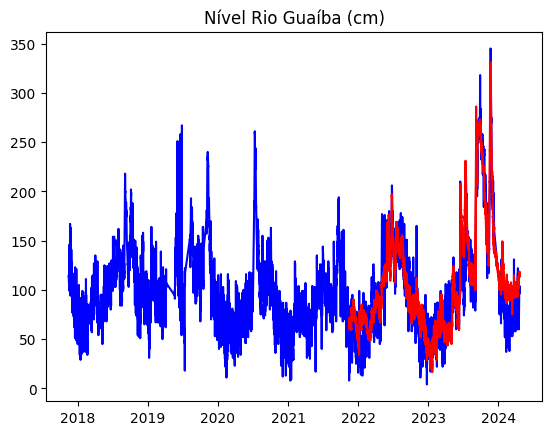

In [9]:
plt.plot(weather['Nível Guaíba (cm)'], color='blue', label='Histórico de treinamento')
plt.plot(predictions['prediction'], color='red', label='Histórico de teste')
plt.title('Nível Rio Guaíba (cm)')
plt.show()